For demo, see the throw.ipynb

Autoformer

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, df, context_length, prediction_length, lags_sequence):
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.lags_sequence = lags_sequence
        self.max_lag = max(lags_sequence)
        self.required_past_length = context_length + self.max_lag

        self.values = df['requests'].values
        self.features = df[['memory', 'cpu']].values

        self.length = len(df) - self.required_past_length - prediction_length + 1

        self.static_real = np.array([df['cpu'].mean(), df['memory'].mean()])
        self.static_cat = np.array([0])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # extract values
        past_values = self.values[idx : idx + self.required_past_length]
        future_values = self.values[idx + self.required_past_length : idx + self.required_past_length + self.prediction_length]
        
        # compute mean and std for normalization (per sample)
        mean = past_values.mean()
        std = past_values.std()
        std = std if std > 0 else 1.0

        # normalize both past and future values
        norm_past_values = (past_values - mean) / std
        norm_future_values = (future_values - mean) / std

        past_time_features = self.features[idx : idx + self.required_past_length]
        future_time_features = self.features[idx + self.required_past_length : idx + self.required_past_length + self.prediction_length]

        past_observed_mask = ~np.isnan(past_values)
        future_observed_mask = ~np.isnan(future_values)

        return {
            'past_values': torch.tensor(norm_past_values, dtype=torch.float),
            'past_time_features': torch.tensor(past_time_features, dtype=torch.float),
            'past_observed_mask': torch.tensor(past_observed_mask, dtype=torch.float),
            'future_values': torch.tensor(norm_future_values, dtype=torch.float),
            'future_time_features': torch.tensor(future_time_features, dtype=torch.float),
            'future_observed_mask': torch.tensor(future_observed_mask, dtype=torch.float),
            'static_real_features': torch.tensor(self.static_real, dtype=torch.float),
            'static_categorical_features': torch.tensor(self.static_cat, dtype=torch.long),
        }


In [3]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [4]:
lags_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # can include 0 if needed
context_len = 11  # 21 - max(lags_seq)
prediction_len = 1 # prediction Length


In [5]:
dataset = TimeSeriesWindowDataset(df, context_length=context_len, prediction_length=prediction_len, lags_sequence=lags_seq)

In [6]:
loader = DataLoader(dataset, batch_size=64, shuffle=True)
for batch in loader:
    print("past values:", batch['past_values'], end="\n")  
    print("past_time_features: ",batch['past_time_features'].shape, end="\n") 
    print("past_observed_mask: ",batch['past_observed_mask'].shape, end="\n")
    print("future_values: ",batch['future_values'].shape, end="\n") 
    print("future_time_series: ",batch['future_time_features'].shape, end="\n") 
    print("future_observed_mask: ",batch['future_observed_mask'].shape, end="\n") 
    break


past values: tensor([[ 0.6154,  1.0300,  1.5137,  ..., -2.0337, -0.8819, -0.4212],
        [-0.0028,  0.8188,  0.1146,  ...,  1.2297, -0.8831, -0.9418],
        [-0.6047, -1.2731, -0.4710,  ...,  0.3310,  0.3310, -0.6047],
        ...,
        [-1.3137, -0.7793, -1.0465,  ...,  0.0223, -1.8480, -1.5808],
        [-1.1943, -0.1133,  1.1840,  ..., -0.7619, -0.3295,  0.5354],
        [ 1.1923, -1.1299, -0.3261,  ..., -1.2192, -1.4276, -1.5765]])
past_time_features:  torch.Size([64, 21, 2])
past_observed_mask:  torch.Size([64, 21])
future_values:  torch.Size([64, 1])
future_time_series:  torch.Size([64, 1, 2])
future_observed_mask:  torch.Size([64, 1])


MODEL CONFIGURATION

In [7]:
from transformers import AutoformerForPrediction, AutoformerConfig
config = AutoformerConfig(
    context_length=context_len,
    prediction_length=prediction_len,
    lags_sequence=lags_seq,
    input_size=1,
    num_time_features=2,
    static_categorical_cardinalities=[1],
    static_real_features=2,
)

model = AutoformerForPrediction(config)

/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50  #

Training Part

In [10]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        # Move batch tensors to the same device as model
        batch = {k: v.to(device) for k, v in batch.items()}

        output = model(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_values=batch['future_values'],
            future_time_features=batch['future_time_features'],
            # static_real_features=batch['static_real_features'],
            # static_categorical_features=batch['static_categorical_features']
        )

        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 183.2319
Epoch 2/50, Loss: 178.5313
Epoch 3/50, Loss: 177.9230
Epoch 4/50, Loss: 177.4951
Epoch 5/50, Loss: 176.8855
Epoch 6/50, Loss: 176.5266
Epoch 7/50, Loss: 175.9318
Epoch 8/50, Loss: 176.2991
Epoch 9/50, Loss: 175.4235
Epoch 10/50, Loss: 176.4483
Epoch 11/50, Loss: 174.5904
Epoch 12/50, Loss: 174.5143
Epoch 13/50, Loss: 174.0981
Epoch 14/50, Loss: 173.7322
Epoch 15/50, Loss: 173.2556
Epoch 16/50, Loss: 173.0162
Epoch 17/50, Loss: 172.7002
Epoch 18/50, Loss: 172.5393
Epoch 19/50, Loss: 172.3571
Epoch 20/50, Loss: 171.6283
Epoch 21/50, Loss: 171.9142
Epoch 22/50, Loss: 170.9977
Epoch 23/50, Loss: 171.1948
Epoch 24/50, Loss: 171.6167
Epoch 25/50, Loss: 170.9203
Epoch 26/50, Loss: 170.1724
Epoch 27/50, Loss: 170.5570
Epoch 28/50, Loss: 170.0403
Epoch 29/50, Loss: 169.7915
Epoch 30/50, Loss: 169.3565
Epoch 31/50, Loss: 169.6290
Epoch 32/50, Loss: 169.5378
Epoch 33/50, Loss: 169.2801
Epoch 34/50, Loss: 168.8239
Epoch 35/50, Loss: 169.1423
Epoch 36/50, Loss: 168.5699
E

Evaluation Part

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def evaluate_forecast(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R2': round(r2, 4)
    }

In [13]:
model.eval()

# Grab a batch
for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    break

# Generate predictions
with torch.no_grad():
    outputs = model.generate(
        past_values=batch['past_values'],
        past_time_features=batch['past_time_features'],
        past_observed_mask=batch['past_observed_mask'],
        future_time_features=batch['future_time_features'],
        # static_real_features=batch['static_real_features'],  # if you're using these
        # static_categorical_features=batch['static_categorical_features'],
    )

normalized_forecast = outputs.sequences  

loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)   # [B, 1, 1]
scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)  # [B, 1, 1]

scale[scale == 0] = 1.0

rescaled_forecast = normalized_forecast * scale + loc

first_pred = rescaled_forecast[:, 0, :]  # [batch_size, 1]
true_values = batch['future_values']


true_values.cpu()
first_pred.cpu()
# print("Ground truth:\n", true_values)
print(evaluate_forecast(true_values.cpu().numpy(), first_pred.cpu().numpy()))

{'MSE': 14.1841, 'RMSE': 3.7662, 'MAE': 1.7164, 'R2': -0.1207}


Evaluation on entire dataset

In [14]:
model.eval()
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # print("past values:", batch['past_values'], end="\n")
        outputs = model.generate(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_time_features=batch['future_time_features'],
        )

        # normalized_forecast = outputs.sequences

        # loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)
        # scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)
        # scale[scale == 0] = 1.0

        # rescaled_forecast = normalized_forecast * scale + loc
        first_pred = outputs.sequences[:, 0, :]
        # First-step forecast


        all_y_true.append(batch['future_values'].cpu().numpy())
        # print("True values: ",batch['future_values'].cpu().numpy(), end="\n")
        all_y_pred.append(first_pred.cpu().numpy())


# Flatten all results
y_true = np.concatenate(all_y_true).flatten()
y_pred = np.concatenate(all_y_pred).flatten()


print("y_true:", y_true)




# Evaluate
metrics = evaluate_forecast(y_true, y_pred)
# print("Evaluation Metrics (Autoformer Model):", metrics)


y_true: [-1.1669161   0.02857365 -0.1548781  ... -1.0879778  -1.2483041
  1.2746837 ]


In [15]:
print("Evaluation Metrics (Autoformer Model):", metrics)

Evaluation Metrics (Autoformer Model): {'MSE': 13.9092, 'RMSE': 3.7295, 'MAE': 1.3396, 'R2': -0.1005}


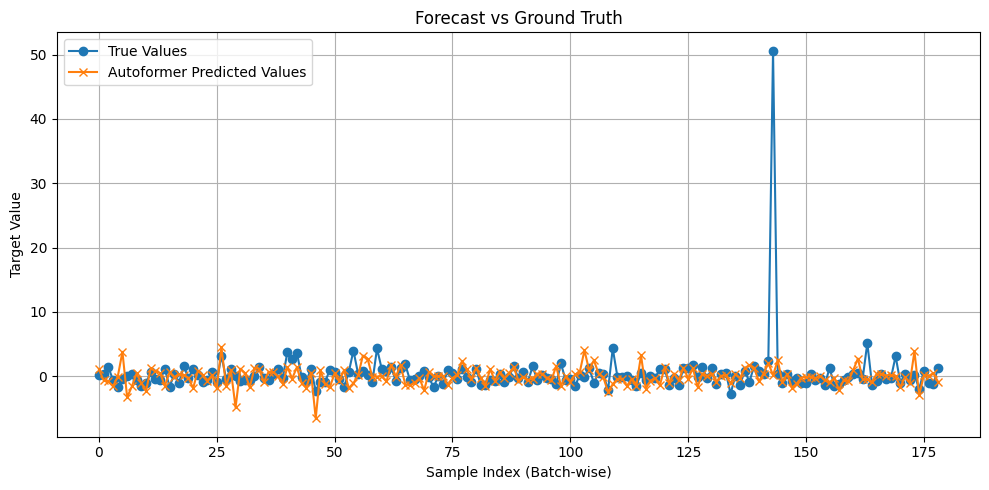

[-0.7627965   0.91247755  2.7240963  -0.470039   -0.5224723  -0.90566313
  0.40082029  0.37229338  0.08315416  0.18260287  0.02447263 -1.752024
 -0.11698005 -1.1297158   3.8807356  -2.9979675   0.16485083  0.04593443
  0.43172827 -0.8642304 ]
[-0.06196277  0.29040894  0.44058785 -0.44868347  5.1511636  -1.3595625
 -0.7496601   0.27893865 -0.44835916 -0.3419203   3.1110115  -1.008069
  0.27876568 -0.5304885   0.24276686 -2.0424283   0.8431501  -1.0879778
 -1.2483041   1.2746837 ]


In [16]:
import matplotlib.pyplot as plt

# #single batch plotting
# y_true = true_values.cpu().numpy().flatten()
# y_pred = first_pred.cpu().numpy().flatten()

# entire dataset
y_true = y_true.flatten()
y_pred = y_pred.flatten()


# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true[7000:], label="True Values", marker='o')
plt.plot(y_pred[7000:], label="Autoformer Predicted Values", marker='x')
plt.title("Forecast vs Ground Truth")
plt.xlabel("Sample Index (Batch-wise)")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(y_pred[-20:])
print(y_true[-20:])

Evaluation on a single batch

In [ ]:
# model.eval()

# # Grab a batch
# for batch in loader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     break

# # Generate predictions
# with torch.no_grad():
#     outputs = model.generate(
#         past_values=batch['past_values'],
#         past_time_features=batch['past_time_features'],
#         past_observed_mask=batch['past_observed_mask'],
#         future_time_features=batch['future_time_features'],
#         # static_real_features=batch['static_real_features'],  # if you're using these
#         # static_categorical_features=batch['static_categorical_features'],
#     )

# normalized_forecast = outputs.sequences  

# loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)   # [B, 1, 1]
# scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)  # [B, 1, 1]

# scale[scale == 0] = 1.0

# rescaled_forecast = normalized_forecast * scale + loc

# first_pred = rescaled_forecast[:, 0, :]  # [batch_size, 1]
# true_values = batch['future_values']


# true_values.cpu()
# first_pred.cpu()
# # print("Ground truth:\n", true_values)
# print(evaluate_forecast(true_values.cpu().numpy(), first_pred.cpu().numpy()))

##### INITIAL MODEL CONFIGURATION

In [ ]:
outputs.sequences

In [ ]:
# Unsqueeze loc and scale for broadcasting
loc = output.loc.unsqueeze(1)      # [10, 1] -> [10, 1, 1]
scale = output.scale.unsqueeze(1)  # [10, 1] -> [10, 1, 1]

# Decode
normalized_forecast = outputs.sequences
rescaled_forecast = normalized_forecast * scale + loc

print("Rescaled forecast shape:", normalized_forecast.shape)
print("Rescaled forecast:", rescaled_forecast.shape)


In [ ]:
outputs.sequences.shape

In [ ]:
true_values = batch['future_values']
print("Ground truth:", true_values)
print("Prediction:", rescaled_forecast)


In [ ]:
first_pred = rescaled_forecast[:, 0, :]  # shape: [10, 1]
true_values = batch['future_values']  # shape: [10, 1]
print("Ground truth:", true_values)
print("Prediction:", first_pred)

In [ ]:
{'MSE': 13260.2734, 'RMSE': 115.1533, 'MAE': 78.879, 'R2': -235.7719}



import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))

test_target_pd = test_target.to_series()
pred_series_pd = nbeats_pred_series.to_series()

plt.plot(test_target_pd, label="Actual Requests", linewidth=2, color="black")

# Plot predicted data with better visibility
plt.plot(pred_series_pd, label="Predicted Requests", linestyle="dashed", linewidth=2.5, color="blue", alpha=0.8)

plt.title("Actual vs Predicted Requests")
plt.xlabel("Time")
plt.ylabel("Requests")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
metMap = {
    'tcn': {
        'mse': 154520.58,
        'rmse': 393.09106,
        'mae': 103.23221,
        'r2': 0.0077,
    },
    'autoformer': {
        'mse': 22674526208.0,
        'rmse': 150580.6303,
        'mae': 19200.0566,
        'r2': -347573.1562,
    },
    'nbeats': {
        'mse': 156958.16,
        'rmse': 396.17944,
        'mae': 106.8795,
        'r2':  -0.007927895,
    },
    'arima': {
        'mse': 8.47,
        'rmse': 2.90,
        'mae': 4.751214,
        'r2': -0.6134726,
    },

}

In [ ]:
import matplotlib.pyplot as plt

def plot_metric_comparison_colorful_annotated(metMap):
    models = list(metMap.keys())
    mse = [metMap[model]['mse'] for model in models]
    rmse = [metMap[model]['rmse'] for model in models]
    mae = [metMap[model]['mae'] for model in models]

    metrics = ['MSE', 'RMSE', 'MAE']
    values = [mse, rmse, mae]

    colors = ['skyblue', 'lightcoral', 'mediumseagreen']  # TCN, Autoformer, N-BEATS

    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        bars = plt.bar(models, values[i], color=colors)
        plt.title(f'{metric} Comparison')
        plt.ylabel(metric)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Annotate values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.1f}',
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# Usage
plot_metric_comparison_colorful_annotated(metMap)
